In [1]:
# https://icepack.github.io/notebooks/how-to/01-performance/

In [2]:
import firedrake
from firedrake import (
    sqrt, exp, max_value, inner, as_vector, Constant, dx, interpolate
)

Lx, Ly = 640e3, 80e3
ny = 20
nx = int(Lx / Ly) * ny
area = Lx * Ly

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)
Q = firedrake.FunctionSpace(mesh, "CG", 1)
V = firedrake.VectorFunctionSpace(mesh, "CG", 1)

/home/firedrake/firedrake/lib/python3.10/site-packages/pytools/__init__.py:2484: UserWarning: unable to find git revision
  warn("unable to find git revision")


In [3]:
x, y = firedrake.SpatialCoordinate(mesh)

x_c = Constant(300e3)
X = x / x_c

B_0 = Constant(-150)
B_2 = Constant(-728.8)
B_4 = Constant(343.91)
B_6 = Constant(-50.57)
B_x = B_0 + B_2 * X**2 + B_4 * X**4 + B_6 * X**6

f_c = Constant(4e3)
d_c = Constant(500)
w_c = Constant(24e3)

B_y = d_c * (
    1 / (1 + exp(-2 * (y - Ly / 2 - w_c) / f_c)) +
    1 / (1 + exp(+2 * (y - Ly / 2 + w_c) / f_c))
)

z_deep = Constant(-720)
z_b = interpolate(max_value(B_x + B_y, z_deep), Q)


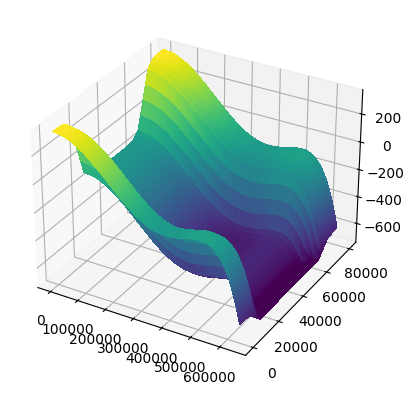

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig = plt.figure()
axes = fig.add_subplot(projection="3d")
firedrake.trisurf(z_b, axes=axes);

In [5]:
outfile = firedrake.File("output/bed_rock.pvd")
outfile.write(z_b)

In [6]:
A = Constant(20)
C = Constant(1e-2)

In [7]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m,
)

def friction(**kwargs):
    variables = ("velocity", "thickness", "surface", "friction")
    u, h, s, C = map(kwargs.get, variables)

    p_W = ρ_W * g * max_value(0, -(s - h))
    p_I = ρ_I * g * h
    N = max_value(0, p_I - p_W)
    τ_c = N / 2

    u_c = (τ_c / C)**m
    u_b = sqrt(inner(u, u))

    return τ_c * (
        (u_c**(1 / m + 1) + u_b**(1 / m + 1))**(m / (m + 1)) - u_c
    )

In [8]:
a = Constant(0.3)


In [9]:
import icepack

model = icepack.models.IceStream(friction=friction)

In [10]:
h_0 = interpolate(Constant(100), Q)
s_0 = icepack.compute_surface(thickness=h_0, bed=z_b)

In [11]:
import tqdm

def run_simulation(solver, h, s, u, time, dt):
    num_steps = int(final_time / dt)
    progress_bar = tqdm.trange(num_steps)
    for step in progress_bar:
        h = solver.prognostic_solve(
            dt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h_0,
        )
        s = icepack.compute_surface(thickness=h, bed=z_b)

        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C,
        )

        min_h = h.dat.data_ro.min()
        avg_h = firedrake.assemble(h * dx) / area
        description = f"avg, min h: {avg_h:4.2f}, {min_h:4.2f}"
        progress_bar.set_description(description)
        
    return h, s, u

In [12]:
dt = 3.0
final_time = 900.0

In [13]:
default_opts = {
    "dirichlet_ids": [1],
    "side_wall_ids": [3, 4],
    "diagnostic_solver_type": "icepack",
    "diagnostic_solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "tolerance": 1e-8,
    },
}
default_solver = icepack.solvers.FlowSolver(model, **default_opts)

In [14]:
u_0 = default_solver.diagnostic_solve(
    velocity=interpolate(as_vector((90 * x / Lx, 0)), V),
    thickness=h_0,
    surface=s_0,
    fluidity=A,
    friction=C,
)

In [15]:
h_900, s_900, u_900 = run_simulation(
    default_solver, h_0, s_0, u_0, final_time, dt
)

avg, min h: 334.62, 71.59: 100%|██████████| 300/300 [03:38<00:00,  1.37it/s] 


In [16]:
dt = 5.0
final_time = 20000

In [17]:
# h, s, u = run_simulation(
#     default_solver, h_900, s_900, u_900, final_time, dt
# )

In [18]:
# import icepack.plot

# fig, axes = icepack.plot.subplots()
# axes.get_yaxis().set_visible(False)
# triangles = firedrake.tripcolor(
#     h_900, shading="gouraud", axes=axes
# )
# fig.colorbar(triangles, fraction=0.01, pad=0.046);

In [19]:
fast_opts = {
    "dirichlet_ids": [1],
    "side_wall_ids": [3, 4],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "snes_line_search_type": "cp",
    },
}
fast_solver = icepack.solvers.FlowSolver(model, **fast_opts)

In [20]:
h, s, u = run_simulation(
    fast_solver, h_900, s_900, u_900, final_time, dt
)

avg, min h: 1173.35, 5.04: 100%|██████████| 4000/4000 [13:12<00:00,  5.04it/s] 


In [21]:
faster_opts = {
    "dirichlet_ids": [1],
    "side_wall_ids": [3, 4],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "ksp_type": "cg",
        "pc_type": "mg",
        "pc_mg_cycle_type": "w",
        "snes_line_search_type": "cp",
    },
    "prognostic_solver_parameters": {
        "ksp_type": "gmres",
        "pc_type": "ilu",
    },
}
faster_solver = icepack.solvers.FlowSolver(model, **faster_opts)

In [22]:
h, s, u = run_simulation(
    faster_solver, h_900, s_900, u_900, final_time, dt
)

avg, min h: 1173.35, 5.04: 100%|██████████| 4000/4000 [11:43<00:00,  5.68it/s] 


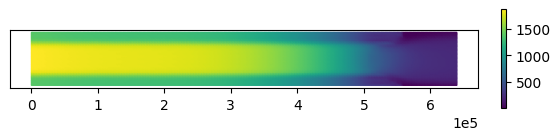

In [23]:
import icepack.plot

fig, axes = icepack.plot.subplots()
axes.get_yaxis().set_visible(False)
triangles = firedrake.tripcolor(
    h, shading="gouraud", axes=axes
)
fig.colorbar(triangles, fraction=0.01, pad=0.046);

In [24]:
outfile = firedrake.File("output/output.pvd")
outfile.write(h)

In [48]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.array([(Lx * k / nx, 0, 0.5) for k in range(nx + 1)])

ss = np.array(s.at(xs[:,0:2], tolerance=1e-10))
hs = np.array(h.at(xs[:,0:2], tolerance=1e-10))
bs = np.array(b.at(xs[:,0:2], tolerance=1e-10))

fig, axes = plt.subplots()
axes.plot(xs[:, 0] / 1e3, bs, color="black")
axes.plot(xs[:, 0] / 1e3, ss - hs, color="blue")
axes.plot(xs[:, 0] / 1e3, ss, color="blue")
axes.set_xlabel("distance along centerline (km)")
axes.set_ylabel("elevation (m)");

NameError: name 'b' is not defined